# Prvi domaci zadatak iz predmeta vestacka inteligencija
## Esmir Pljakic 0205/2017, OS

In [1]:
# Ucitavanje potrebnih biblioteka koje su neophodne za dalji rad
from pylab import *
%matplotlib inline

import skimage
from skimage import *
import matplotlib
import matplotlib.pyplot as plt
import random 
import math
import numpy as np
style.use('dark_background')

In [2]:
"""""
input : arg - koordinate tacke
output : value - vrednost funkcije u toj tacki
"""""
def f(arg):
    x = arg[0]
    y = arg[1]
    return 2 - 0.1*(np.cos(5*x*np.pi) + np.cos(5*y*np.pi)) - np.square(x) - np.square(y)

Prikaz zadate funkcije na intervalu u kojem cemo traziti njen maksimum, a to je x,y = [-1,1].

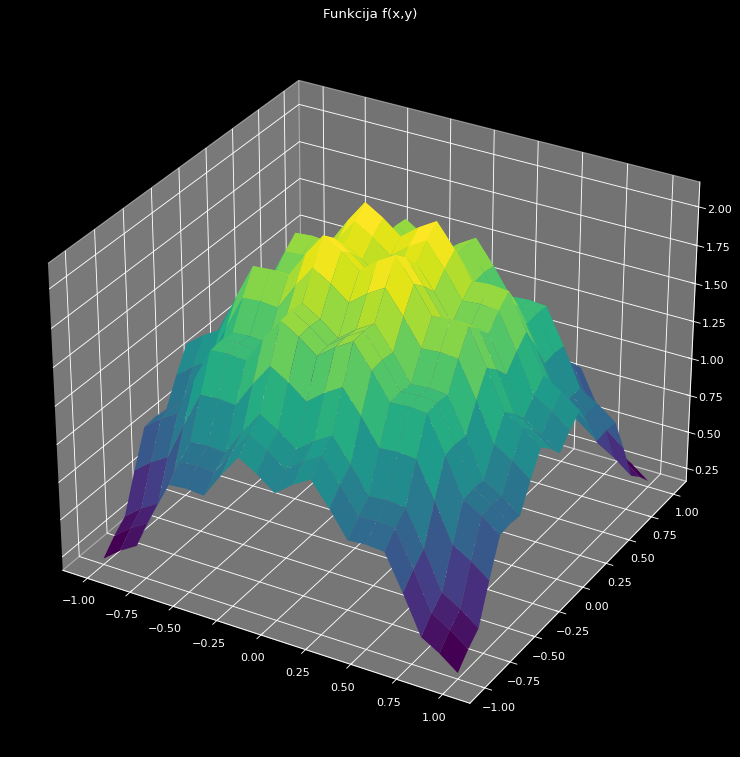

In [3]:
# Definisemo matricu koordinata na osnovu koje cemo iscrtati funkciju
x = np.arange(-1, 1.0+0.1, 0.1)
y = np.arange(-1, 1.0+0.1, 0.1)
X, Y = np.meshgrid(x,y)
function = np.zeros(X.shape)
function = f([X,Y])

# Prikaz funkcije
fig = plt.figure(figsize=(12,12), dpi=80)
ax = plt.axes(projection ='3d')
ax.plot_surface(X, Y, function, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Funkcija f(x,y)')
plt.show()

## Generisanje suseda
Kod ovih metoda pretrage susede nekog cvora je potrebno generisati slucajnom modifikacijom tog cvora. Odlucio sam u svakoj pretrazi implementirati generisanje suseda na sledeci nacin:
<hr>
1) Cvoru kojeg je potrebno modifikovati dodajem slucajnu promenljivu koja ima uniformnu raspodelu na intervalu [-0.005, 0.005]. Uniformna raspodela zato sto zelim da svaki broj, na tom intervalu, bude izabran sa podjednakom verovatnocom.
<hr>
2) Ukoliko smo prekoracili interval nasih promneljivih, a to je [-1, 1], vrsimo zaokruzivanje na maksimalnu/minimalnu vrednost tog intervala.

## Simulirano kaljenje
Simulirano kaljenje jeste algoritam koji pripada grupi algoritama sa lokalnom pretragom. Karakteristika algoritama sa lokalnom pretragom je ta da razmatraju samo kompletna resenja i da krecuci se kroz graf sa kompletnim resenjima traze ono najbolje. Simulirano kaljenje funkcionise tako sto imamo neko pocetno stanje, temperaturu koju kroz iteracije smanjujemo i broj iteracija u kojima trazimo najbolje resenje za trenutnu temperaturu. Pocetno stanje se inicijalizuje slucajno u opsegu od [-1, 1], potom se generise, slucajnom modifikacijom, njegov naslednik. Nakon generisanja naslednika poredimo vrednosti funkcija u oba stanja, ukoliko je vrednsot funkcije naslednika veca nego vrednost funkcije trenutnog cvora, onda za trenutni cvor uzimamo naslednika, a ukoliko vrednost nije veca onda mozemo za trenutni cvor uzeti naslednika ali sa verovatnocom e^(-delta/T). Na pocetku sam probao sa linearnim opadanjem temperature, ali rezultati su bili losi i onda sam promenio da temperatura opada eskponencijalno, jer sam zeleo da algoritam pri samom kraju ima malu verovatnocu prihvatanja losijeg resenja. Maksimalno delta koje se moze javiti u ovom slucaju jeste 2.13, stoga je pocetna temperatura od koje polazim 20 (e^(-2.13/20) = 0.9).
<hr>
Modifikaciju sam implementirao tako da se u svakoj stotoj iteraciji za trenutni cvor uzima najbolji cvor koji je do tada pronadjen.

In [4]:
def simulirano_kaljenje(T, speed, M, modification):
    # Temperatura
    t_start = T
    t_end = 0.001
    delta_t = 0
    t_current = t_start
    
    # Nalazenje ukupnog broja iteracija
    k = 0
    iterations = 0
    if speed == 'normal':
        while t_current > t_end:
            delta_t = t_start - t_start*np.exp(-0.4*k)
            t_current = t_start - delta_t
            k += 0.05
            iterations += 1
    elif speed == 'fast':
        while t_current > t_end:
            delta_t = t_start - t_start*np.exp(-0.4*k)
            t_current = t_start - delta_t
            k += 0.5
            iterations += 1
    else :
        while t_current > t_end:
            delta_t = t_start - t_start*np.exp(-0.4*k)
            t_current = t_start - delta_t
            k += 0.01
            iterations += 1
    
    # Uprosecene vrednosti za 100 realizacija sa razlicitim pocetnim resenjima
    realisation = np.zeros(iterations)
    
    # Cilj
    f_goal = 2.12
    
    # Broj razvijenih cvorova do cilja po iteracijama
    kon_cvor = np.zeros(100)
    
    # Ciljna vrednost funkcije po iteracijama
    f_ciljno = np.zeros(100)
    
    # Ponavljanje eksperimenta sto puta
    for m in range(0, 100):
        # Brojevi generisanih cvorova do pronalaska cilja
        cvor = 0
        stop = False
        
        # Niz u koje ce se cuvati najbolji rezultat svake iteracije
        x_start = [random.uniform(-1, 1), random.uniform(-1, 1)]
        x_best = np.zeros((iterations,2))
        f_best = np.zeros(iterations)
        
        # Trenutne koordinate i trenutna vrednost funkcije u toj tacki
        x_current = np.zeros(2)
        f_current = 0
        
        # Resenje koje ce nakon modifikacije dati sused tj. novo resenje x'
        x_good = np.zeros(2)
        x_good = x_start
        f_good = f(x_start)
        
        # Najbolji rezultat
        f_the_best = 0
        xy_the_best = np.zeros(2)
        
        # Modifikacija
        f_mod = 0
        xy_mod = np.zeros(2)

        # Simulirano kaljenje
        t_current = t_start
        delta_t = 0
        delta = 0
        step_xy = 0.005
        k = 0
        # Prva petlja - dok temp. ne padne na 0
        for j in range (0, iterations, 1):
            # Druga petlja - trazenje boljeg rezultata na istoj temp.
            for i in range(0, M, 1):
                # Slucajna modifikacija trenutnog resenja
                x_current[0] = x_good[0] + random.uniform(-0.005, 0.005)
                x_current[1] = x_good[1] + random.uniform(-0.005, 0.005)
                
                # Zaokruzivanje ukoliko smo presli opseg
                x_current[0] = max(min(x_current[0], 1), -1)
                x_current[1] = max(min(x_current[1], 1), -1)

                # Prihvatanje novog resenja
                f_new = f(x_current)
                delta = abs(f_new - f_current)
                if f_new > f_current:
                    accept = True
                else:
                    p = np.exp(-delta/t_current)
                    if random.uniform(0, 1) < p:
                        accept = True
                    else:
                        accept = False

                # Stanje iz kog ce se novom modifikacijom napraviti novi sused
                if accept == True:
                    x_good[0] = x_current[0]
                    x_good[1] = x_current[1]
                    f_good = f_current 
                f_current = f_new
                
                """""
                cvor += 1
                if f_new >= f_goal:
                    stop = True 
                    break
            
            kon_cvor[m] = cvor
            if stop == True:
                break
            """""
           
            # Cuvanje konacnog resenja dobijenog na odredjenoj temp.
            x_best[j, 0] = x_good[0]
            x_best[j, 1] = x_good[1]
            f_best[j] = f_good

            # Najbolje do sada pronadjeno resenje
            f_the_best = f_best[j]
            xy_the_best = x_best[j]

            # Eksponencijalno smanjenje temp. nakon svake iteracije
            delta_t = t_start - t_start*np.exp(-0.3*k)
            t_current = t_start - delta_t
            #print(t_current)
            if speed == 'normal':
                k += 0.05
            elif speed == 'fast':
                k += 0.5
            else :
                k += 0.01

            # Modifikacija
            if f_the_best >= f_mod:
                f_mod = f_the_best
                xy_mod = xy_the_best
            if modification == 'on':
                if ((j/100)%1) == 0:
                    x_good[0] = xy_mod[0]
                    x_good[1] = xy_mod[1]
                    f_good = f_mod
        
        f_ciljno[m] = f_the_best
        realisation += f_best
        
    # Usrednjavanje 
    realisation = realisation/100
    
    """""
    # Iscrtavanje najboljih resenja tokom razlicitih vrednsoti temp.
    t = np.arange(0.0, iterations, 1.0)
    plt.figure(figsize = (12,8))
    plt.plot(t, realisation, 'y',  label='Simulirano kaljenje')
    plt.legend()
    plt.show()
    
    print('Maximum of this function is :' , f_the_best)
    print('Coordinates are : x=', xy_the_best[0], ', y=', xy_the_best[1])
    """""
    
    return f_ciljno

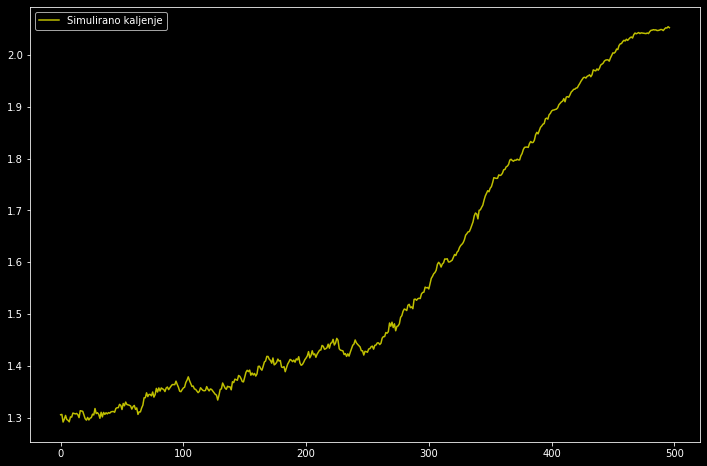

Maximum of this function is : 2.122213013193146
Coordinates are : x= -0.18098129734636914 , y= 0.1741061534018622


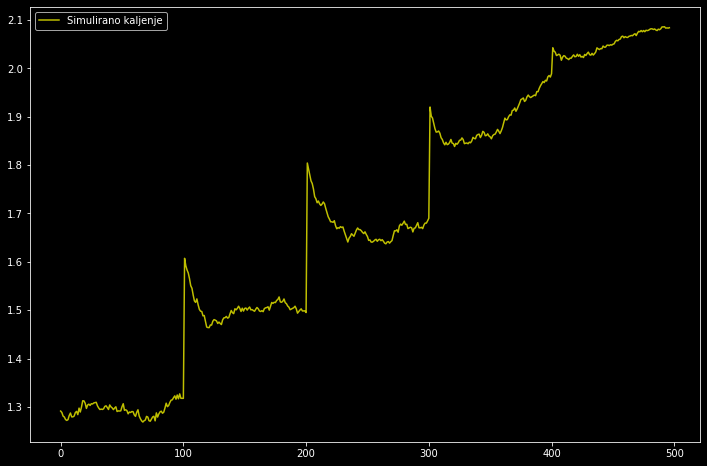

Maximum of this function is : 2.071983744185719
Coordinates are : x= 0.21949353881439573 , y= -0.24418859654514463


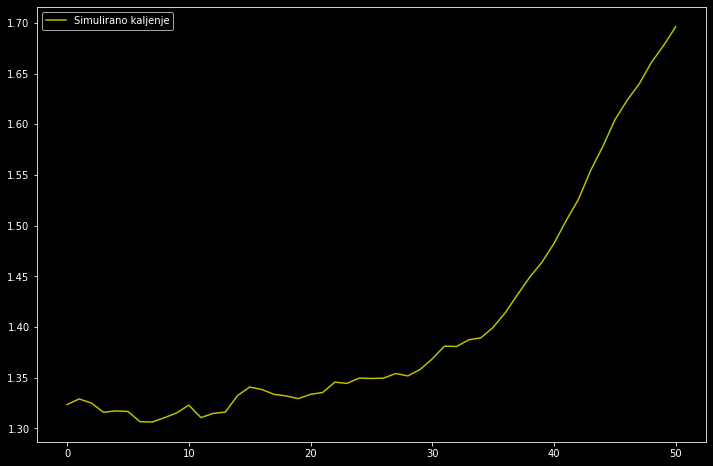

Maximum of this function is : 0.9674168048632886
Coordinates are : x= 0.5585225945811501 , y= 0.8629831839183317


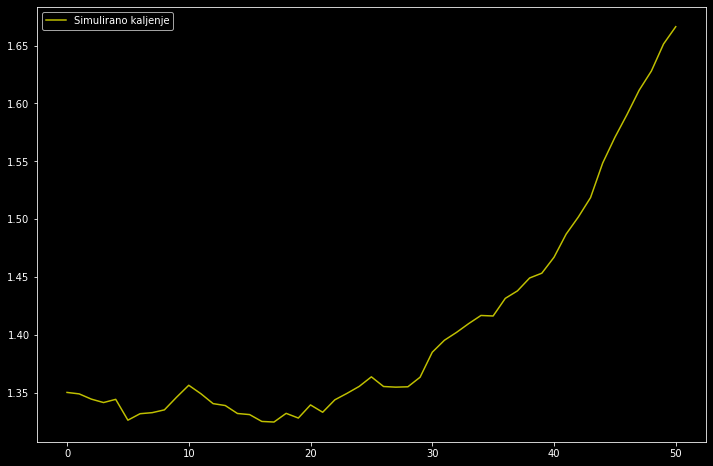

Maximum of this function is : 1.753214952613591
Coordinates are : x= 0.6109724890082966 , y= 0.2392186318387396


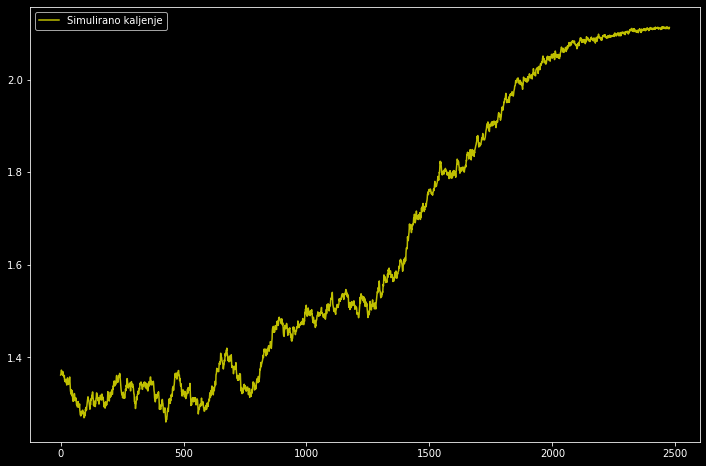

Maximum of this function is : 2.096858702397381
Coordinates are : x= 0.1405355080088957 , y= 0.16784412008135322


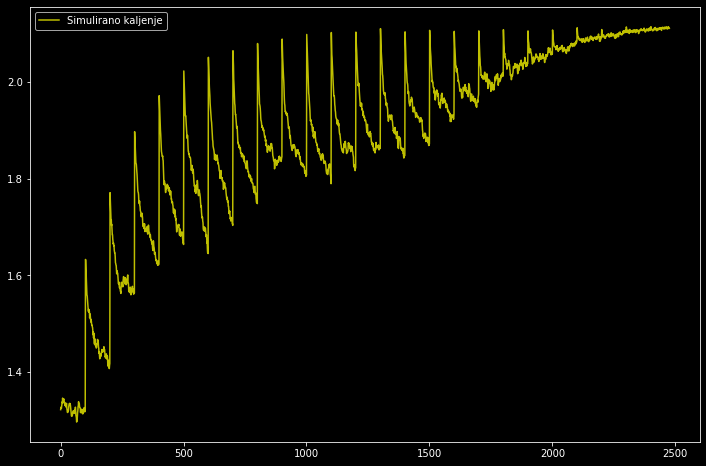

Maximum of this function is : 2.1183364358415173
Coordinates are : x= -0.18924724151193348 , y= -0.2104730144262503


In [22]:
simulirano_kaljenje(20, 'normal', 100, 'off')
simulirano_kaljenje(20, 'normal', 100, 'on')
simulirano_kaljenje(20, 'fast', 100, 'off')
simulirano_kaljenje(20, 'fast', 100, 'on')
simulirano_kaljenje(20, 'slow', 100, 'off')
simulirano_kaljenje(20, 'slow', 100, 'on')

### Zakljucak
Modifikacija koju smo uveli u velikoj meri pomaze algoritmu pri pronalasku maksimuma funkcije. Ta pomoc se znatno vidi ukoliko je opadanje temperature sporije. Ukoliko imamo brzo opadanje temperature moze se desiti da algoritam ne pronadje maksimum date funkcije. Medjutim koliko god da je temperatura mala na kraju, moze se desiti da ta verovatnoca, iako je mala, bude ostvarena i da se prihvati neko resenje koje nije bolje od prethodnih. Sa grafika se vidi da algoritam kako se temperatura smanjuje postaje gramziviji i da se priblizava vrednosti koja odgovara vrednosti maksimumu date funkcije.

## Pretraga po snopu
Pretraga po snopu takodje pripada algoritmima lokalne pretrage. Ovaj algoritam funkcionise tako sto na pocetku generismo, na slucajan nacni, odgovarajuci broj pocetnih stanja. Nakon sto smo generisali pocetna stanja vrsimo mutaciju generisanih cvorova i od svakog cvora generisemo k novih naslednika. Od svih generisanih naslednika biramo k najboljih, odnosno biramo k naslednika cija je vrednost funkcije najveca. Ceo ovaj proces se izvrsava iterativno.
<hr>
Size u ovom algoritmu predstavlja velicinu trenutne populacije koja se razmatra i ona u prvoj iteraciji moze biti jednaka vrednosti k, koja predstavlja broj najboljih resenja koja cemo cuvati, ali i ne mora. Vec u drugoj iteraciji ova vrednost se postavlja na vrednost k, jer zelimo da imamo k najboljih resenja.

In [5]:
"""""
input : f_x - vrednosti funkcije
        x   - koordinate
output : f_x, x - sortirane vrednosti funkcije u opadajucem nizu
"""""
def sort_array(f_x, x):
    for i in range(len(f_x)):
        swap = i + np.argmax(f_x[i:])
        (f_x[i], f_x[swap]) = (f_x[swap], f_x[i])
        (x[i], x[swap]) = (x[swap], x[i])
    return f_x, x

In [6]:
def pretraga_po_snopu(k , N, size):
    # Uprosecene vrednosti za 100 realizacija sa razlicitim pocetnim resenjima
    realisation = np.zeros(N)
    
    # Cilj
    f_goal = 2.12
    
    # Broj razvijenih cvorova do cilja po iteracijama
    kon_cvor = np.zeros(100)
    
    # Ciljna vrednost funkcije po iteracijama
    f_ciljno = np.zeros(100)
    
    for m in range(0, 100):
        # Brojevi generisanih cvorova do pronalaska cilja
        cvor = 0
        stop = False
        
        # Generisanje pocetnih cvorova na slucajan nacin
        x = np.zeros((size,2))
        for i in range(0, size):
            x[i,0] = random.uniform(-1,1)
            x[i,1] = random.uniform(-1,1)
            
        # Cvor sa najboljim resenjem
        xy_the_best = np.zeros(2)
        f_the_best = 0
        
        # Cuvanje k najboljih naslednika u svakoj iteraciji
        x_best = np.zeros((k,2))
        f_best = np.zeros(k)
        
        # Niz u koje ce se cuvati uproseceni rezultat svake iteracije
        f_good = np.zeros(N)

        # Pretraga po snopu
        step_xy = 0.01      
        # Petlja po iteracijama
        for i in range(0, N):
            # Kreiramo nasu granicu u kojoj ce biti smesteni potomci trenutnih cvorova
            x_current = np.zeros((size*k,2))
            f_current = np.zeros(size*k)
            
            # Generisanje naslednika iz trenutnih cvorova i smestanje u granicu
            for j in range(0, size):
                for l in range(0, k):
                    x_current[k*j+l,0] = x[j, 0] + random.uniform(-0.005, 0.005)
                    x_current[k*j+l,1] = x[j, 1] + random.uniform(-0.005, 0.005)
                    
                    # Zaokruzivanje ukoliko smo presli opseg
                    x_current[k*j+l,0] = max(min(x_current[k*j+l,0], 1), -1)
                    x_current[k*j+l,1] = max(min(x_current[k*j+l,1], 1), -1)
                    f_current[k*j+l] = f(x_current[k*j+l])
                   
                    """""
                    cvor += 1
                    if f_current[k*j+l] >= f_goal:
                        stop = True
                        break
                
                if stop == True:
                    break
            
            if stop == True:
                kon_cvor[m] = cvor
                break
            """""

            # Sortiranje cvorova u granici
            f_current, x_current = sort_array(f_current, x_current)

            # Promena velicine niza u kojem cemo cuvati k najboljih cvorova
            size = k
            x = np.zeros((size,2))
            
            # Prepisivanje iz granice prvih k najboljih cvorova
            f_sum = 0
            for j in range(0, k):
                f_best[j] = f_current[j]
                x_best[j] = x_current[j]
                x[j] = x_best[j]
                f_sum += f_best[j]

            # Belezenje prosecnog rezultata od k naboljih resenja
            f_good[i] = f_sum/k

            # Pamcenje dosadasnjeg najboljeg resenja
            f_the_best = f_best[0]
            xy_the_best = x_best[0]
        
        f_ciljno[m] = f_the_best
        realisation += f_good
    
    # Usrednjavanje 
    realisation = realisation/100
    
    """""
    # Iscrtavanje najboljih uprosecenih resenja tokom iteracija
    t = np.arange(0.0, N, 1.0)
    plt.figure(figsize = (12,8))
    plt.plot(t, realisation, 'y',  label='Pretraga po snopu')
    plt.legend()
    plt.show()
            
    print('K best :', f_best)
    print('Maximum of this function is :' , f_the_best)
    print('Coordinates are : x=', xy_the_best[0], ', y=', xy_the_best[1])
    """""
    
    return f_ciljno

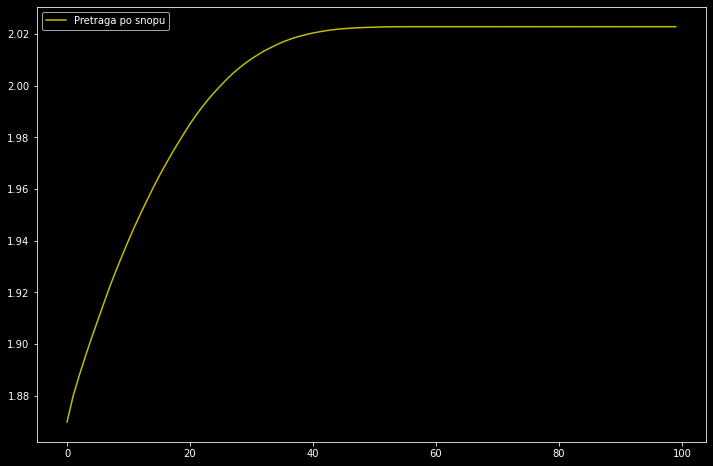

K best : [2.12602406 2.12602283 2.1260225  2.1260213  2.12602018 2.12601857
 2.1260131  2.12600734]
Maximum of this function is : 2.126024063429395
Coordinates are : x= -0.1847922721383306 , y= -0.1847322538960646


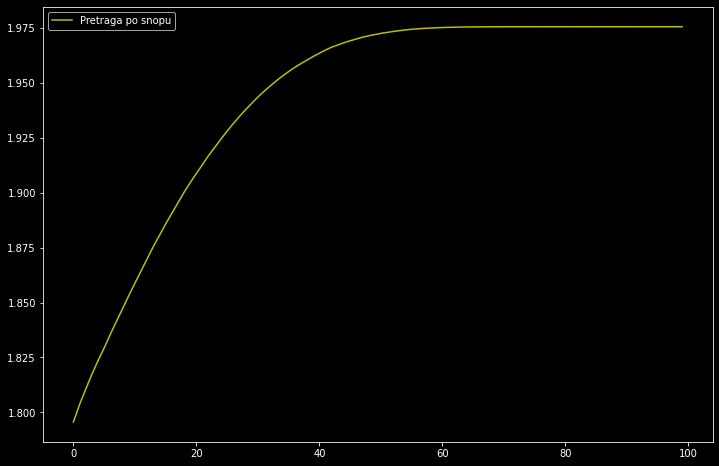

K best : [2.12601786 2.12598898 2.12593791 2.125836  ]
Maximum of this function is : 2.1260178583545963
Coordinates are : x= -0.1845380678203717 , y= -0.18424657600504435


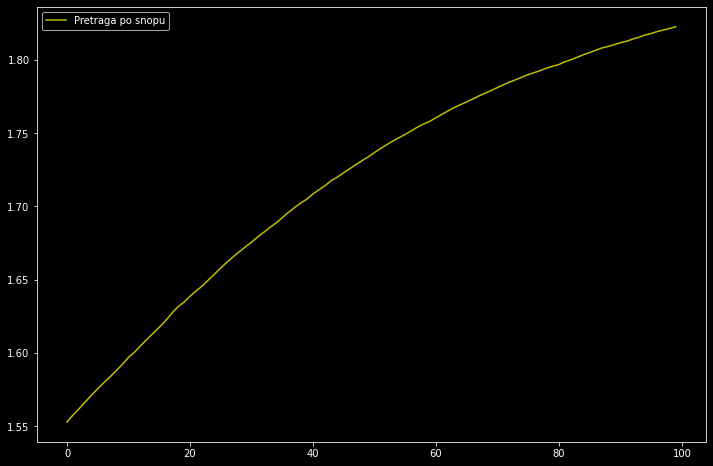

K best : [2.12594985 2.12565025]
Maximum of this function is : 2.125949848592592
Coordinates are : x= -0.18341648734289115 , y= 0.18677395660781265


In [57]:
pretraga_po_snopu(8, 100, 10)
pretraga_po_snopu(4, 100, 7)
pretraga_po_snopu(2, 100, 4)

### Zakljucak
Algoritam pretrage po snopu u velikoj meri zavisi od cvorova koji su generisani na pocetku, na slucajan nacin. Ukoliko se medju tim resenjima nalazi neko resenje koje je priblizno vrednosti maksimumu date funkcije nas algoritam ce pronaci maksimum te funkcije relativno brzo. Ukoliko se desi da u pocetnoj populaciji nemamo resenje koje je blisko maksimumu, nas algoritam moze imati poteskoca, jer naslednici tj. susedi koji se generisu, generisu se na slucajan nacin, stoga se moze desiti da dobijemo naslednike koji su gori od svojih prethodnika. Moze se zakljuciti sa grafika da ukoliko imamo populaciju koja je na pocetku velika, a i veliki broj resenja koja cuvamo da ce algoritam vrlo brzo pronaci maksimum funkcije. To nije slucaj kod populacije koja je premala, jer je mala verovatnoca da u pocetnoj populaciji dobijemo resenje koje je priblizno najboljem resenju.

## Genetski algoritam
Najpoznatiji algoritam lokalne pretrage koji pokusava replicirati odredjene mehanizme teorije evolucije kao sto su selekcija, ukrstanje i mutacija jedinki. Resenja se kod ovog algoritma nazivaju hromozomi, a skup svih resenja se naziva populacija. Ideja je da generisanjem novih populacija dobijamo jedinke koje su sve bolje i bolje u odnosu na svoje roditelje, ali naravno ne postoji nikakva garancija za to. Na samom pocetku na slucajan nacin generisemo pocetnu populaciju, nakon toga vrsimo selekciju i to na nacin da biramo one hromozome cija je verovatnoca proporcionalna njenoj vrednosti funkcije. Nakon dobijenih selektovanih hromozoma iz populacije vrsimo ukrstanje na nacin da sabiramo prvi gen oba hromozoma i delimo sa 2, isto to radimo i za drugi gen. Na kraju dolazi mutacija sa verovatnocom 0.4.
<hr>
Kodiranje resenja: svaki hromozom se sastoji od dva gena (xy). Prvi gen predstavlja vrednost po x-osi, a drugi gen predstavlja vrednost po y-osi.

In [7]:
"""""
input : population - trenutna populacija koja se salje na ukrstanje
        f_sum - suma vrednosti funkcije u svim hromozomima date populacije
output: vratimo hromozom koji ima najvecu verovatnocu da bude izabran
"""""
def selekcija(population, f_sum):
    prob = random.uniform(0,1)
    sum_prob = 0
    for i in range(0, len(population)):
        sum_prob += f(population[i])/f_sum
        
        if prob <= sum_prob:
            return population[i]

In [8]:
"""""
input : population1 - prvi hromozom
        population2 - drugi hromozom
output : novi hromozom koji je nastao ukrstanjem ulaznih hromozoma
"""""
def ukrstanje(population1, population2):
    return [(population1[0]+population2[0])/2, (population1[1]+population2[1])/2]

In [9]:
"""""
input : population - hromozom
output : novi hromozom koji je generisan mutiranjem ulaznog hromozoma
"""""
def mutacija(population):
    prob = random.uniform(0,1)
    x = population[0]
    y = population[1]
    
    if prob < 0.4:
        x = population[0] + random.uniform(-0.01, 0.01)
        y = population[1] + random.uniform(-0.01, 0.01)
    
        x = max(min(x, 1), -1)
        y = max(min(y, 1), -1)
        
    return [x, y]

In [10]:
def genetski_algoritam(size, N):
    # Uprosecene vrednosti za 100 realizacija sa razlicitim pocetnim resenjima
    realisation = np.zeros(N)
    
    # Cilj
    f_goal = 2.12
    
    # Broj razvijenih cvorova do cilja po iteracijama
    kon_cvor = np.zeros(100)
    
    # Ciljna vrednost funkcije po iteracijama
    f_ciljno = np.zeros(100)
    
    for m in range(0, 100):
        # Brojevi generisanih cvorova do pronalaska cilja
        cvor = 0
        stop = False
        
        # Hromozom sa najboljim resenjem
        xy_the_best = np.zeros(2)
        f_the_best = 0

        # Niz u koje ce se cuvati uproseceni rezultat svake iteracije
        f_good = np.zeros(N)

        # Slucajno generisanje pocetne populacije
        population = np.zeros((size, 2))
        f_population = np.zeros(size)
        for i in range(size):
            population[i,0] = random.uniform(-1, 1)
            population[i,1] = random.uniform(-1, 1)
            f_population[i] = f(population[i])

        # Genetski algoritam
        for i in range(0, N):
            # Sortiranje populacije u opadajucem redosledu
            f_population, population = sort_array(f_population, population)

            # Cuvanje najboljeg resenja iz populacije
            f_the_best = f(population[0])
            xy_the_best = population[0]

            # Suma funkcija datih hromozoma u datoj generaciji
            f_sum = 0
            for j in range(0, size):
                f_sum += f(population[j])

            # Generisanje nove populacije
            next_population = np.zeros((size,2))
            for j in range(0, size):
                # Selekcija
                first = selekcija(population, f_sum)
                second = selekcija(population, f_sum)
                # Ukrstanje
                cross = ukrstanje(first, second)
                # Mutacija
                next_population[j] = mutacija(cross)
                f_population[j] = f(next_population[j])
                
                """""
                cvor += 1
                if f_population[j] >= f_goal:
                    stop = True
                    break
            
            if stop == True:
                kon_cvor[m] = cvor
                break
            """""

            # Trenutna populacija postaje nova
            population = next_population

            # Belezenje prosecnog rezultata u datoj generaciji
            f_good[i] = f_sum/size
        
        f_ciljno[m] = f_the_best
        realisation += f_good
    
    # Usrednjavanje 
    realisation = realisation/100
    
    """""
    # Iscrtavanje najboljih uprosecenih resenja tokom iteracija
    t = np.arange(0.0, N, 1.0)
    plt.figure(figsize = (12,8))
    plt.plot(t, realisation, 'y',  label='Genetski algoritam')
    plt.legend()
    plt.show()
            
    print('Maximum of this function is :' , f_the_best)
    print('Coordinates are : x=', xy_the_best[0], ', y=', xy_the_best[1])  
    """""
    
    return f_ciljno

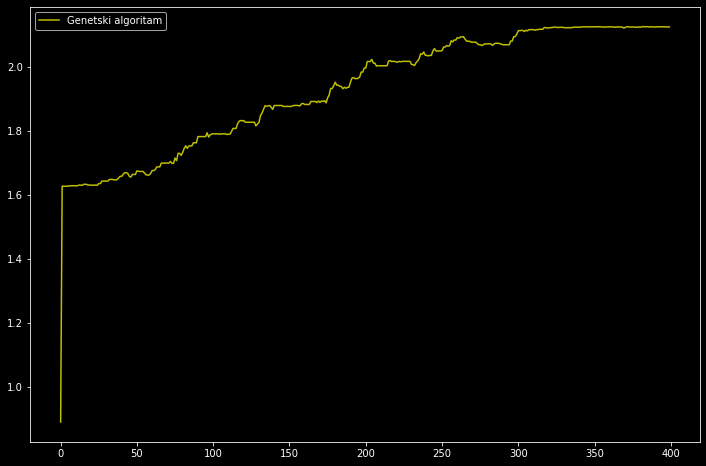

Maximum of this function is : 2.125411128990234
Coordinates are : x= -0.1840310582373491 , y= -0.19166808461702795


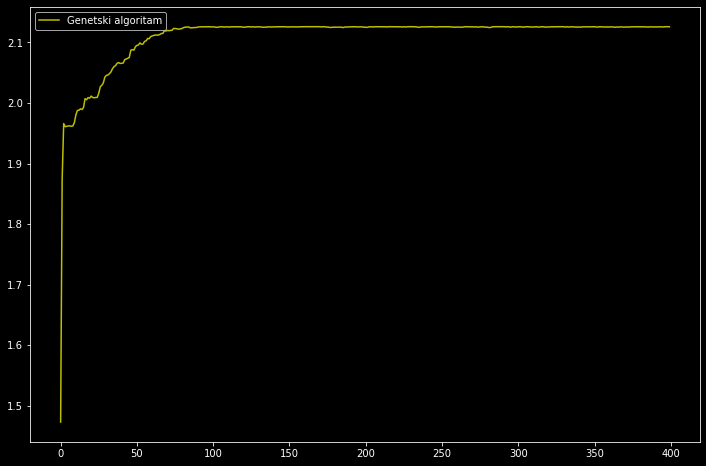

Maximum of this function is : 2.1260177905137727
Coordinates are : x= 0.18445807257905036 , y= 0.1854533175710561


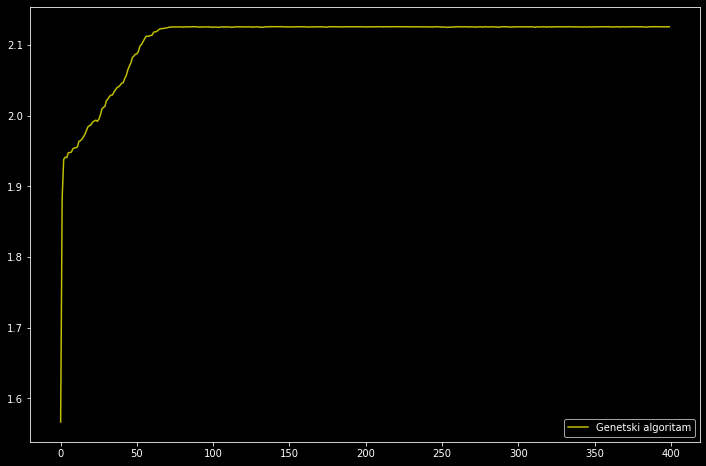

Maximum of this function is : 2.1260188034911325
Coordinates are : x= -0.18524344035435839 , y= -0.18541462988453628


In [58]:
genetski_algoritam(2, 400)
genetski_algoritam(5, 400)
genetski_algoritam(10, 400)

#### Zakljucak
<hr>
Glavna razlika ovog algoritma i pretrage po snopu jeste ukrstanje resenja. Taj korak nam omogucava da u ranijim iteracijama pronadjemo valjano resenje ukrstanjem njegovih roditelja. Sa grafika se vidi ukoliko imamo vecu populaciju to cemo brze pronaci maksimum funkcije, tj. potrebno nam je manje iteracija za pronalazak maksimuma. Za mali broj populacije vidimo kako se algoritam muci da pronadje resenje, ali na kraju ipak uspeva da ga pronadje.

## Histogrami

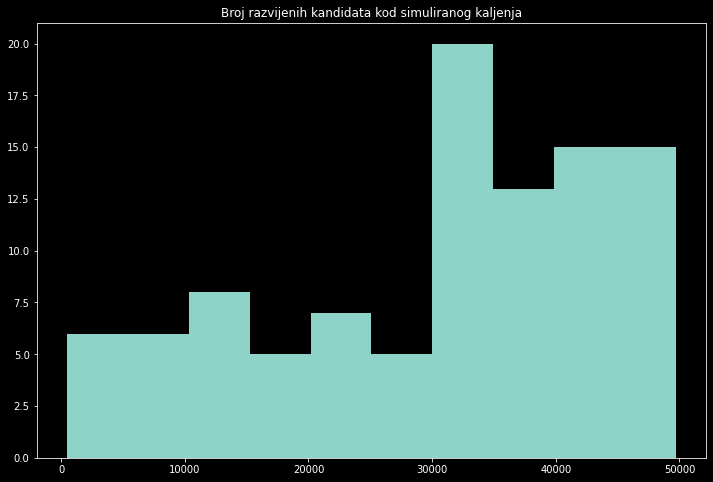

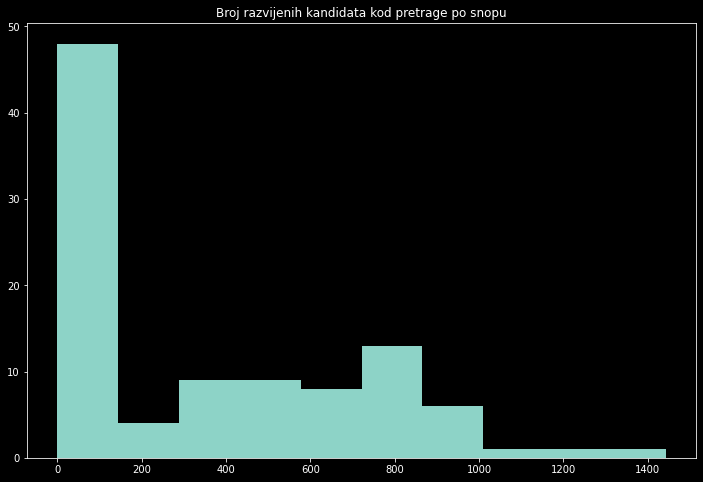

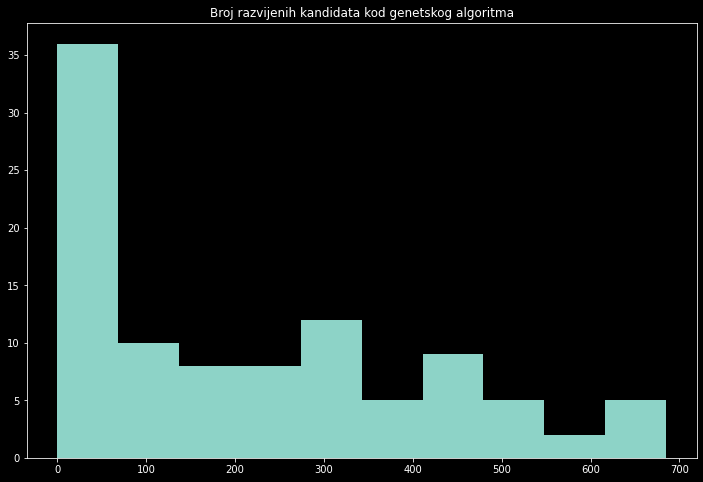

In [78]:
hist_kaljenje = simulirano_kaljenje(20, 'normal', 100, 'on')
plt.figure(figsize = (12,8))
plt.hist(hist_kaljenje, bins=10, range=(hist_kaljenje.min(), hist_kaljenje.max()))
plt.title('Broj razvijenih kandidata kod simuliranog kaljenja')
plt.show()

hist_snop = pretraga_po_snopu(4, 100, 7)
plt.figure(figsize = (12,8))
plt.hist(hist_snop, bins=10, range=(hist_snop.min(), hist_snop.max()))
plt.title('Broj razvijenih kandidata kod pretrage po snopu')
plt.show()

hist_gen = genetski_algoritam(5, 400)
plt.figure(figsize = (12,8))
plt.hist(hist_gen, bins=10, range=(hist_gen.min(), hist_gen.max()))
plt.title('Broj razvijenih kandidata kod genetskog algoritma')
plt.show()

### Zakljucak
Na datim histogramima se nalazi informacija o broju razvijenih cvorova, pre pronalaska najboljeg resenja, za svaki od algoritama. Sa histograma za simulirano kaljenje vidimo da je taj broj generisanih kandidata zaista velik, ali to je zbog toga sto sam funkciji prosledio da na svakoj temperaturi potrazi sto resenja. Broj kod pretrage po snopu i kod genetskog algoritma je znatno manji i vidi se da oni u velikom broju slucajeva vec u prvih sto/dvesta generisanih kandidata uspevaju da pronadju maksimum. Moze se zakljuciti da je genetski algoritam najefikasniji u smislu broja generisanih kandidata do pronalaska maksimuma funkcije.

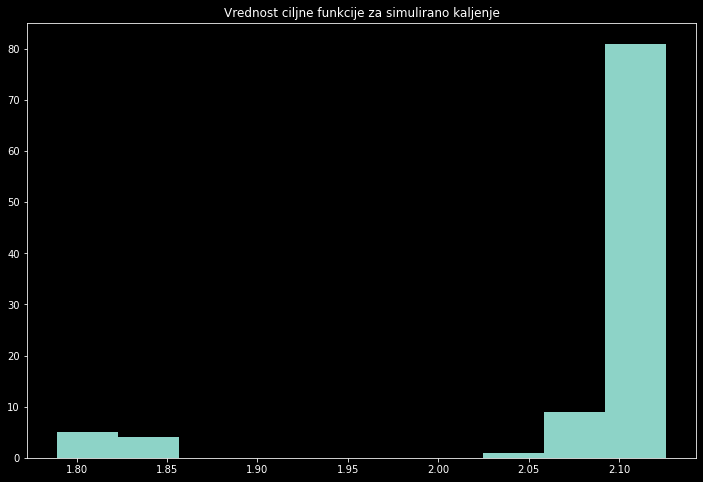

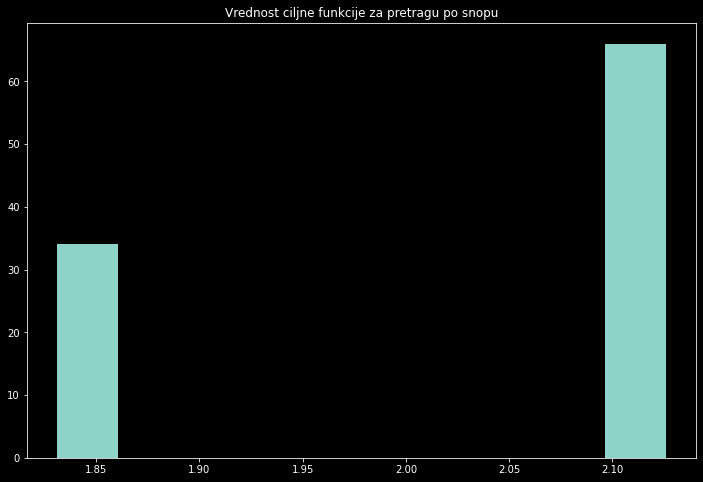

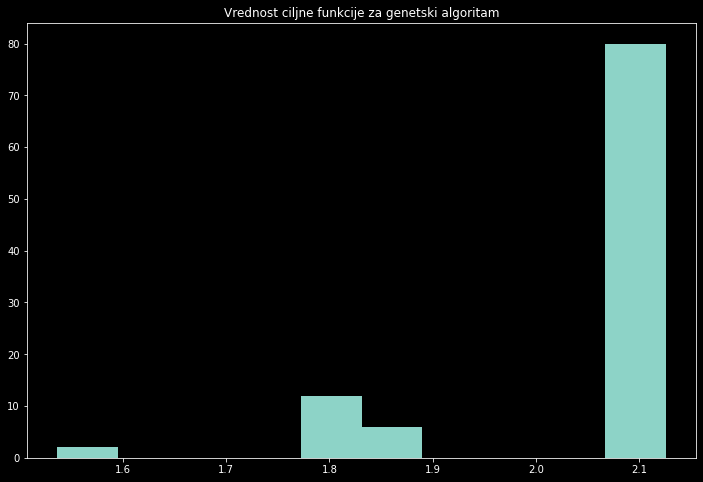

In [86]:
hist_kaljenje = simulirano_kaljenje(20, 'normal', 100, 'on')
plt.figure(figsize = (12,8))
plt.hist(hist_kaljenje, bins=10, range=(hist_kaljenje.min(), hist_kaljenje.max()))
plt.title('Vrednost ciljne funkcije za simulirano kaljenje')
plt.show()

hist_snop = pretraga_po_snopu(6, 100, 10)
plt.figure(figsize = (12,8))
plt.hist(hist_snop, bins=10, range=(hist_snop.min(), hist_snop.max()))
plt.title('Vrednost ciljne funkcije za pretragu po snopu')
plt.show()

hist_gen = genetski_algoritam(6, 400)
plt.figure(figsize = (12,8))
plt.hist(hist_gen, bins=10, range=(hist_gen.min(), hist_gen.max()))
plt.title('Vrednost ciljne funkcije za genetski algoritam')
plt.show()

### Zakljucak
Sa histograma se moze videti da svi algoritmi u velikom broju slucajeva i to cak 80 od 100 uspeju da pronadju maksimum funkcije. Medjutim algoritam pretrage po snopu, kao sto sam pre vec naglasio, u velikoj meri zavisi od pocetne populacije kako je generisana i da se moze desiti da ne pronadje maksimum, sto se da videti i sa histograma. Zakljucak je da je genetski algoritam najbolji po broju generisanih kadnidata do pronalaska resenja, ali i po procentu uspesnosti pronalaska maksimuma funkcije.